# RTS-96 Results

It's time to convert the MATLAB code I wrote to pull RTS-96 data out of Jenny's Excel spreadsheets into Julia code.

I actually don't think I have enough time for this right now. Perhaps for the upcoming journal article.

___
Okay, I changed my mind. It's more important now to connect various parts of existing RTS-96 data to the temporal instanton solver.

In [3]:
include("../src/tmp_inst_rts96.jl")

psData = psDataLoad()

# unpack psDL (boilerplate):
(Sb,f,t,r,x,b,Y,bustype,
Gp,Gq,Dp,Dq,Rp,Rq,
Pmax,Pmin,Qmax,Qmin,Plim,
Vg,Vceiling,Vfloor,
busIdx,N,Nr,Ng,k) = unpack_psDL(psData)

# Get instanton code into workspace:
include("../src/TemporalInstanton.jl")
include("../src/TrustRegionSubproblem.jl")

using TemporalInstanton, TrustRegionSubproblem

In [2]:
using Interact
using PyPlot

INFO: Loading help data...


In [4]:
####### DATA ENTRY ########

# Static
Ridx = find(Rp) # Vector of renewable nodes
Y = full(Y) # Full admittance matrix (slack not removed)
slack = 1 # Index of slack node
k = k # Conventional generator participation factors
tau = 0.2 # Heating constant
G0 = [Gp,Gp.*0.95,Gp.*0.9]
D0 = [Dp,Dp.*0.95,Gp.*0.9]
P0 = [Rp,Rp,Rp]
kQobj = 0 # Should always be zero; objective has no constant term
c = 10 # RHS of line temperature constraint
kQtheta = -c # Move to LHS so we have Q(z) = 0
lines = [(f[i],t[i]) for i in 1:length(f)]

line = lines[100]

(60,71)

In [28]:
# Changing
for line in lines
    display(line)
end

(1,2)

(1,3)

(1,5)

(2,4)

(2,6)

(3,9)

(3,24)

(4,9)

(5,10)

(6,10)

(7,8)

(7,27)

(8,9)

(8,10)

(9,11)

(9,12)

(10,11)

(10,12)

(11,13)

(11,14)

(12,13)

(12,23)

(13,23)

(13,39)

(14,16)

(15,16)

(15,21)

(15,21)

(15,24)

(16,17)

(16,19)

(17,18)

(17,22)

(18,21)

(18,21)

(19,20)

(19,20)

(20,23)

(20,23)

(21,22)

(23,41)

(25,26)

(25,27)

(25,29)

(26,28)

(26,30)

(27,33)

(27,48)

(28,33)

(29,34)

(30,34)

(31,32)

(32,33)

(32,34)

(33,35)

(33,36)

(34,35)

(34,36)

(35,37)

(35,38)

(36,37)

(36,47)

(37,47)

(38,40)

(39,40)

(39,45)

(39,45)

(39,48)

(40,41)

(40,43)

(41,42)

(41,46)

(42,45)

(42,45)

(43,44)

(43,44)

(44,47)

(44,47)

(45,46)

(49,50)

(49,51)

(49,53)

(50,52)

(50,54)

(51,57)

(51,72)

(52,57)

(53,58)

(54,58)

(55,56)

(56,57)

(56,58)

(57,59)

(57,60)

(58,59)

(58,60)

(59,61)

(59,62)

(60,61)

(60,71)

(61,71)

(62,64)

(63,64)

(63,69)

(63,69)

(63,72)

(64,65)

(64,67)

(65,66)

(65,70)

(66,69)

(66,69)

(67,68)

(67,68)

(68,71)

(68,71)

(69,70)

(73,21)

(66,47)

(71,73)

In [5]:
# Create instance of instanton problem:
Qobj,A,b,Qtheta = temporalInstanton(Ridx,Y,slack,k,tau,line,G0,P0,D0)

G_of_x = (Qobj,0,kQobj)
Q_of_x = (Qtheta,0,kQtheta)

# Translate and rotate twice:
K_of_w,R_of_x,x_star,Rkernel,Reigvec = tr_trans_rotate(G_of_x,Q_of_x,A,b)



Qtheta = full(R_of_x[1])
D = K_of_w[1]
#D = round(D,9)
poles = [D[i,i]*Qtheta[i,i] for i in setdiff(1:size(D,1),find(diag(Qtheta).==0))]
d = K_of_w[2]

# for mu in linspace(-1000,1000,10)
#     w = find_w(mu,D,d,Qtheta)
#     display((w'*w)[1])
# end

w = find_w(0,D,d,Qtheta)
w'*w

#display([maximum(w) find(w.==maximum(w))])

# z = tr_map_back(w,Rkernel,Reigvec,x_star)

1-element Array{Float64,1}:
 17.1889

Slider{Float64}([Input{Float64}] 7.5,"c",7.5,5.0:0.1:10.0)

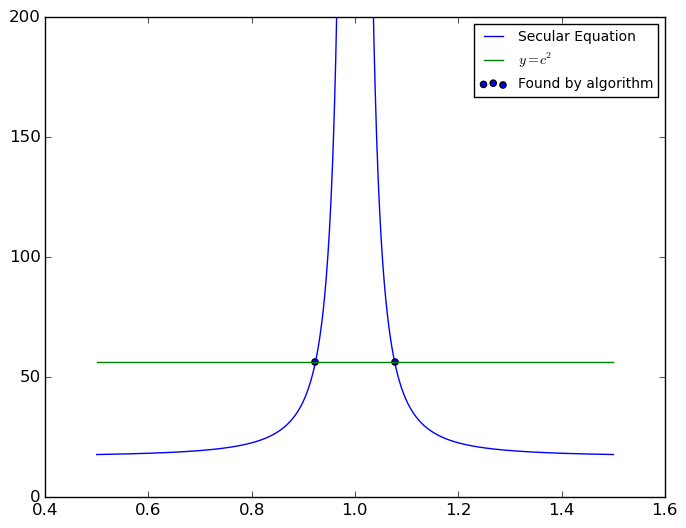

In [6]:
mu_vals = linspace(0.5*minimum(poles),1.5*maximum(poles),1000)

fig = figure()
@manipulate for c = 5:0.1:10; withfig(fig) do
        solutions,vectors = tr_solve_secular(D,d,Qtheta,c)
        # mu = solutions[1]
        # display(length(solutions))
        # w = find_w(mu,D,d,Qtheta)
        # (w'*w)[1]

        s_vals = [sumabs2(find_w(mu,D,d,Qtheta)) for mu in mu_vals]
        plot(mu_vals,s_vals)
        hold = true
        plot([mu_vals[1],mu_vals[end]],[c^2,c^2])
        ylim([0,200]) #ylim([0,2*c^2])
        xlim = [mu_vals[1],mu_vals[end]]
        scatter(solutions,c^2*ones(length(solutions)))
        legend(["Secular Equation",L"y = c^2","Found by algorithm"],fontsize=10)
    end
end

In [7]:
# Solve secular equation:
solutions,vectors = tr_solve_secular(D,d,Qtheta,5.)

# Translate back to original variables:
xvec = tr_map_back(vectors[1],Rkernel,Reigvec,x_star)

deviations = Array(Vector{Float64},0)
angles = Array(Vector{Float64},0)
alpha = Float64[]
n = size(Y,1)
nr = length(Ridx)
for t = 1:int(length(G0)/size(Y,1))
    push!(deviations,xvec[(nr+n)*(t-1)+1:(nr+n)*(t-1)+nr])
    push!(angles,xvec[(nr+n)*(t-1)+nr+1:(nr+n)*(t-1)+nr+n-1])
    push!(alpha,xvec[(nr+n)*(t)])
end
display(alpha)

3-element Array{Float64,1}:
 -33.3444  
 -31.8869  
  -0.133827

In [6]:
alpha

3-element Array{Float64,1}:
 -33.934   
 -31.6669  
  -0.603254

In [20]:
sum(deviations[1]) + sum(Rp) + (sum(Gp) - sum(Dp))

34.27569409825987